### Append path because this file is not in the main directory

In [1]:
import sys
sys.path.append("../src/")
sys.path.append("../")

### Import stuff

In [2]:
import numpy as np

import nudobe
from nudobe import constants, functions
from constants import *

#import neutrino mixing matrix function
from functions import U_PMNS

#import multiprocessing

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

import time

# mLRSM

In [3]:
#Parameters

#masses
v_R  = 10*TeV
v_L  = 0.1*eV
m_DR = 4*TeV

#heavy neutrino masses
m_heavy = np.array([10,12,13])*TeV

#mixings
V_ud_R  = V_ud
V_ud_L  = V_ud
xi      = m_b/m_t
theta_L = 0
alpha   = 0

# 1. Get EFT Model
When matching the mLRSM onto the SMEFT one finds that the different SMEFT Wilson coefficients are not independent from each other but rather co-depend on the same mLRSM parameters. Therefore we cannot simply vary SMEFT WCs independently from one another. Instead, we approach this by defining a Python function that generates the SMEFT WCs in dependency on the free mLRSM parameters that we want to vary.
## 1.1 Mass Matrices
First we need to define a function that generates all the relevant mass matrices:

In [4]:
def get_masses(m_min           = 0, 
                ordering        = "NO", 
                Majorana_phases = [0,0], 
                v_R             = 10*TeV, 
                v_L             = 0.1*eV, 
                m_heavy         = np.array([10,12,13])*TeV,
                theta_L         = 0,
               ):
    U = U_PMNS(alpha=Majorana_phases)
    m = m_min
    
    if ordering == "NO" or ordering == "NH":
        m1 = m
        m2 = np.sqrt(m1**2+m21)
        m3 = np.sqrt(m2**2+m32)
    elif ordering == "IO" or ordering == "IH":
        m3 = m
        m2 = np.sqrt(m3**2-m32IO)
        m1 = np.sqrt(m2**2-m21)

    
    #diagonal light neutrino masses
    m_nu = np.diag([m1,m2,m3])*1e-9
    
    #diagonal heavy neutrino masses
    m_nu_R = np.diag(m_heavy)
    
    #non-diagonal light neutrino mass
    M_nu = U@m_nu@U.T
    
    #non-diagonal heavy neutrino mass
    M_nu_R = U@m_nu_R@U.T
    
    #inverse matrices
    M_nu_R_inv = np.linalg.inv(M_nu_R)
    
    M_nu_R_dagger_inv = np.linalg.inv(M_nu_R.T.conjugate())
    
    #non-diagonal yukawa matrices
    M_R = M_nu_R.T.conjugate()/(np.sqrt(2)*v_R)
    M_L = M_R.T.conjugate()
    
    M_nu_L = (np.sqrt(2) * v_L * np.exp(1j*theta_L) * M_L)
    
    #get the dirac yukawa matrix eq.57
    M_nu_D = U@m_nu_R@scipy.linalg.sqrtm(v_L/v_R*np.exp(1j*theta_L) * np.diag([1,1,1])
                                                          - np.linalg.inv(m_nu_R)@m_nu+0j)@U.T
    #return results
    return(m_nu, m_nu_R, M_nu_R, M_nu_R_inv, M_nu_R_dagger_inv, M_nu_D, M_nu_L)

In [5]:
m_nu, m_nu_R, M_nu_R, M_nu_R_inv, M_nu_R_dagger_inv, M_nu_D, M_nu_L = get_masses()

# SMEFT
The general SMEFT Lagrangian relevant for $0\nu\beta\beta$ from mLRSM as given in 1806.02780 is
$\mathcal{L} =  \epsilon_{kl} \epsilon_{mn}\left(L_k^T  \mathcal C^{(5)}C L_m \right)\varphi_l \varphi_n  \\
\quad +   \epsilon_{ij}(L_i^T C \gamma_\mu e)\varphi_j\left[ \mathcal C^{(7)}_{Leu\bar d  \varphi}\,\bar d_R \gamma^\mu u_R+ \mathcal  C^{(7)}_{L\varphi De}\epsilon_{mn} \varphi_m (D^\mu \varphi)_n\right] \\
\quad + \bar e_R C \bar e_R^T\,\left[\mathcal C_{eeud}^{(9)} \bar u_R \gamma_\mu d_R\,  \bar u_R \gamma^\mu d_R + \mathcal  C_{ee\varphi u d}^{(9)} \overline{u}_R \gamma_\mu d_R 
( (i D_\mu \varphi)^\dagger  \tilde \varphi)
+ \mathcal C_{ee\varphi D}^{(9)}( (i D_\mu \varphi)^\dagger  \tilde \varphi)^2\right],$


And the Wilson Coefficients are given by


$\mathcal C^{(5)} =\left({\frac{1}{2}} M_D^T M_{\nu_R}^{-1}M_D-\frac{\sqrt{2}v_Le^{i\theta_L}}{v^2}M_L\right)\,,$

$\mathcal C^{(7)}_{Leu\overline{d}\varphi}  ={\frac{1}{v_R^2}} \left(V_R^{ud}\right)^* \left( M_D^TM_{\nu_R}^{-1} \right)_{ee} ,$

$C^{(7)}_{L\varphi De}  =\frac{2i\xi e^{i\alpha}}{1+\xi^2}\frac{\mathcal C^{(7)}_{Leu\overline{d}\varphi}}{\left(V_R^{ud}\right)^*}\,$

$\mathcal C^{(9)}_{eeud} =-\frac{1}{2 v_R^4} \left(V_{R}^{ud}\right)^2\left[\left(M_{\nu_R}^\dagger\right)^{-1}+\frac{2}{m_{\Delta_R}^2} M_{\nu_R}\right]_{ee},$

$\mathcal C^{(9)}_{ee\varphi u d}=-4\frac{\xi e^{-i\alpha}}{1+\xi^2}\frac{\mathcal C^{(9)}_{eeud}}{V_{R}^{ud}}$

$\mathcal C_{ee \varphi D}^{(9)}=4\frac{\xi^2 e^{-2i\alpha}}{(1+\xi^2)^2}\frac{\mathcal C^{(9)}_{eeud}}{\left(V_{R}^{ud}\right)^2}$

In [6]:
C5         = 1/vev**2 * (M_nu_D.T@M_nu_R_inv@M_nu_D-M_nu_L)[0,0]
C_LeudPhi7 = np.sqrt(2)/vev * (1/v_R**2 *(V_ud_R.conjugate()) * M_nu_D.T@M_nu_R_inv)[0,0]
C_LPhiDe7  = 2j * xi*np.exp(1j * alpha) / (1 + xi**2) * C_LeudPhi7 / V_ud_R.conjugate()
C_eeud9    = 0.88 * (-1 / (2 * v_R**4) * V_ud_R**2 * (M_nu_R_dagger_inv + 2 / m_DR**2 * M_nu_R))[0,0]
C_eePhiud9 = -4 * (xi * np.exp(-1j * alpha)) / (1 + xi**2) * C_eeud9/V_ud_R
C_eePhiD9  = 4 * xi**2 * np.exp(-2j * alpha) / ((1 + xi**2)**2) * C_eeud9/V_ud_R**2

These are related to the operator basis used in $\nu$DoBe via

$C_{LH}^{(5)}       = \left(C^{(5)}\right)_{ee}$

$C_{LeudH}^{(7)}    = C_{Leud\varphi}^{(7)}$

$C_{LHDe}^{(7)}     = C_{L\varphi De}^{(7)}$

$C_{ddueue}^{(9)}   = 4\left(C_{eeud}^{(9)}\right)^*$

$C_{deueH^2D}^{(9)} = -2 \left(C_{ee\varphi ud}^{(9)}\right)^*$

$C_{eeH^4D^2}^{(9)} = -\left(C_{ee\varphi D}^{(9)}\right)^*$

In [7]:
WCs = {"LH(5)"      : C5, 
       "LeudH(7)"   : C_LeudPhi7, 
       "LHDe(7)"    : C_LPhiDe7, 
       "ddueue(9)"  : 4*np.conj(C_eeud9), 
       "deueH2D(9)" : -2 * np.conj(C_eePhiud9), 
       "eeH4D2(9)"  : -np.conj(C_eePhiD9)
      }

In [8]:
model = nudobe.EFT.SMEFT(WCs)

In [9]:
model.half_lives()

,76Ge,82Se,96Zr,100Mo,110Pd,116Cd,124Sn,128Te,130Te,134Xe,136Xe,148Nd,150Nd,154Sm,160Gd,198Pt,232Th,238U
0,3.197971e+28,1.062281e+28,1.980644e+28,1.290206e+28,6.082889e+28,2.826486e+28,2.105402e+28,1.803512e+29,1.064516e+28,1.898183e+29,1.635102e+28,4.390738e+28,5.955310e+27,1.216393e+29,2.518991e+28,4.852194e+28,1.029273e+28,3.100523e+27


## 1.2 Generate the SMEFT Model
After having defined a function that generates the neutrino mass matrices we define yet another function that generates the required SMEFT WCs:

In [10]:
def get_WCs(m_min           = 0, 
            Majorana_phases = [0,0],
            ordering        = "NO",
            v_R             = 10*TeV,
            v_L             = 0.1*eV,
            m_DR            = 4*TeV,
            m_heavy         = np.array([10,12,13])*TeV,
            V_ud_R          = V_ud,
            V_ud_L          = V_ud,
            xi              = m_b/m_t,
            theta_L         = 0,
            alpha           = 0, 
            WC_option       = 0 #0=all, 1= short-range, 2=long-range
           ):

    m_nu, m_nu_R, M_nu_R, M_nu_R_inv, M_nu_R_dagger_inv, M_nu_D, M_nu_L = get_masses(m_min, 
                                                                                    ordering, 
                                                                                    Majorana_phases, 
                                                                                    v_R = v_R, 
                                                                                    v_L = v_L,
                                                                                    m_heavy = m_heavy,
                                                                                    theta_L = theta_L)
    if WC_option == 0:
        C5         = 1/vev**2 * (M_nu_D.T@M_nu_R_inv@M_nu_D-M_nu_L)[0,0]
    else:
        C5         = 0
        
    if WC_option in [0,2]:
        C_LeudPhi7 = np.sqrt(2)/vev * (1/v_R**2 *(V_ud_R.conjugate()) * M_nu_D.T@M_nu_R_inv)[0,0]
        C_LPhiDe7  = 2j * xi*np.exp(1j * alpha) / (1 + xi**2) * C_LeudPhi7 / V_ud_R.conjugate()
    else:
        C_LeudPhi7 = 0
        C_LPhiDe7  = 0
        
    if WC_option in [0, 1]:
        C_eeud9    = 0.88 * (-1 / (2 * v_R**4) * V_ud_R**2 * (M_nu_R_dagger_inv + 2 / m_DR**2 * M_nu_R))[0,0]
        C_eePhiud9 = -4 * (xi * np.exp(-1j * alpha)) / (1 + xi**2) * C_eeud9/V_ud_R
        C_eePhiD9  = 4 * xi**2 * np.exp(-2j * alpha) / ((1 + xi**2)**2) * C_eeud9/V_ud_R**2
    else:
        C_eeud9    = 0
        C_eePhiud9 = 0
        C_eePhiD9  = 0
    
    WCs = {"LH(5)"      : C5, 
           "LeudH(7)"   : C_LeudPhi7, 
           "LHDe(7)"    : C_LPhiDe7, 
           "ddueue(9)"  : 4*np.conj(C_eeud9), 
           "deueH2D(9)" : -2 * np.conj(C_eePhiud9), 
           "eeH4D2(9)"  : -np.conj(C_eePhiD9)
          }
    
    return(WCs)

and we use this function to define the SMEFT models:

In [11]:
def get_model(m_min           = 0, 
              Majorana_phases = [0,0],
              ordering        = "NO",
              v_R             = 10*TeV,
              v_L             = 0.1*eV,
              m_DR            = 4*TeV,
              m_heavy         = np.array([10,12,13])*TeV,
              V_ud_R          = V_ud,
              V_ud_L          = V_ud,
              xi              = m_b/m_t,
              theta_L         = 0,
              alpha           = 0, 
              method          = "SM", 
              WC_option       = 0
              ):
    WCs = get_WCs(m_min           = m_min, 
                  Majorana_phases = Majorana_phases,
                  ordering        = ordering,
                  v_R             = v_R,
                  v_L             = v_L,
                  m_DR            = m_DR,
                  m_heavy         = m_heavy,
                  V_ud_R          = V_ud_R,
                  V_ud_L          = V_ud_L,
                  xi              = xi,
                  theta_L         = theta_L,
                  alpha           = alpha, 
                  WC_option       = WC_option
                 )
    model = nudobe.EFT.SMEFT(WCs, method = method)
    return(model)

# 2. Make T-half - m_min plot

Since the different WCs are dependent on the minimal neutrino mass we cannot simply use the plot_t_half function of nuDoBe. Instead, we have to generate the half-life plots ourselves. (This part is a bit slow and takes a some minutes. Go get a coffee or download joblib and put it on multi-core or just plot less points than we did.)

In [12]:
#lets make a scatter plot
def get_points(N         = 5000, 
               v_R       = 10*TeV, 
               v_L       = 0.1*eV, 
               m_DR      = 4*TeV, 
               m_heavy   = np.array([10,12,13])*TeV,
               xi        = m_b/m_t,
               method    = "SM", 
               isotope   = "76Ge", 
               WC_option = 0,
               normalize = False,
              ):
    
    np.random.seed(0)
    
    #array of neutrino masses in eV
    m_min_array = np.logspace(-4, 0, N)
    
    #store datapoints in arrays
    #minimal neutrino masses
    m   = np.zeros(N)
    
    #half-lives
    t   = np.zeros(N)
    tIO = np.zeros(N)
    
    #effective nu mass
    m_eff = np.zeros(N)
    m_eff_IO = np.zeros(N)
    
    
    #standard-mechanisms PSF
    G01 = nudobe.EFT.LEFT({}).PSFpanda[isotope]["G01"]
    
    #standard-mechanisms NME
    M3 = nudobe.EFT.LEFT({}, method = method).amplitudes(isotope)[1]["nu(3)"]


    for idx in range(N):
        if idx%int(N/100) == 0:
            print(str(np.round(idx/N*100,1))+"%")
        #randomize mass
        m_min    = np.random.choice(m_min_array)

        #randomize phases
        Majorana = 2*np.pi*np.random.random(2)
        theta_L  = 2*np.pi*np.random.random()
        alpha    = 2*np.pi*np.random.random()

        #store mass
        m[idx]   = m_min
        
        if idx == 0:
            #generate model classes
            model = get_model(m_min = m_min, Majorana_phases = Majorana, theta_L = theta_L, 
                              alpha = alpha, v_L = v_L, v_R = v_R, m_DR = m_DR, m_heavy = m_heavy, 
                              xi = xi, method = "SM", WC_option = WC_option)
            modelIO = get_model(m_min = m_min, Majorana_phases = Majorana, theta_L = theta_L, 
                                alpha = alpha, v_L = v_L, v_R = v_R, m_DR = m_DR, m_heavy = m_heavy, 
                                xi = xi, method = "SM", ordering = "IO", WC_option = WC_option)
            if normalize:
                model_standard    = nudobe.EFT.LEFT({}, method = method)
                model_standard_IO = nudobe.EFT.LEFT({}, method = method)
        else:
            #rewrite Wilson Coefficients
            WC = get_WCs(m_min = m_min, Majorana_phases = Majorana, theta_L = theta_L, 
                         alpha = alpha, v_L = v_L, v_R = v_R, m_DR = m_DR, m_heavy = m_heavy, 
                         xi = xi, WC_option = WC_option)
            WCIO = get_WCs(m_min = m_min, Majorana_phases = Majorana, theta_L = theta_L, 
                           alpha = alpha, v_L = v_L, v_R = v_R, m_DR = m_DR, m_heavy = m_heavy, 
                           xi = xi, WC_option = WC_option, ordering = "IO")
            
            for C in WC:
                model.WC[C] = WC[C]
                modelIO.WC[C] = WCIO[C]

        #store half-life
        t[idx]   = model.t_half(isotope)
        tIO[idx] = modelIO.t_half(isotope)
        
        #return m_eff in eV
        m_eff[idx]    = np.absolute(m_e / (g_A**2 * M3 * G01**(1/2)) * t[idx]**(-1/2)) * 1e+9
        m_eff_IO[idx] = np.absolute(m_e / (g_A**2 * M3 * G01**(1/2)) * tIO[idx]**(-1/2)) * 1e+9
        
        #normalize to standard mechanism if desired
        if normalize:
            model_standard.WC["m_bb"] = model_standard._m_eff(alpha    = Majorana, 
                                                              m_min    = m_min,
                                                              ordering = "NO")
            
            model_standard_IO.WC["m_bb"] = model_standard._m_eff(alpha    = Majorana, 
                                                                 m_min    = m_min,
                                                                 ordering = "IO")
            t[idx]        /= model_standard.t_half(isotope)
            tIO[idx]     /= model_standard_IO.t_half(isotope)
            m_eff[idx]    /= model_standard.WC["m_bb"]*1e+9
            m_eff_IO[idx] /= model_standard_IO.WC["m_bb"]*1e+9
    return(m, t, tIO, m_eff, m_eff_IO)

In [13]:
N = 5000#0

start = time.time()
m, t, tIO, m_eff, m_eff_IO = get_points(N       = N, 
                                        v_R     = 10*TeV, 
                                        v_L     = 0.1*eV, 
                                        m_DR    = 4*TeV, 
                                        m_heavy = np.array([10,12,13])*TeV, 
                                        xi      = m_b/m_t,
                                       )
print(time.time()-start)

start = time.time()
m2, t2, tIO2, m_eff2, m_eff_IO2 = get_points(N       = N, 
                                             v_R     = 10*TeV, 
                                             v_L     = 0.1*eV, 
                                             m_DR    = 4*TeV, 
                                             m_heavy = np.array([10,12,13])*TeV, 
                                             xi      = 0,
                                            )
print(time.time()-start)

start = time.time()
m3, t3, tIO3, m_eff3, m_eff_IO3 = get_points(N       = N, 
                                             v_R     = 10*TeV, 
                                             v_L     = 100*eV, 
                                             m_DR    = 4*TeV, 
                                             m_heavy = np.array([10,12,13])*TeV, 
                                             xi      = m_b/m_t,
                                            )
print(time.time()-start)

start = time.time()
m4, t4, tIO4, m_eff4, m_eff_IO4 = get_points(N       = N, 
                                             v_R     = 10*TeV, 
                                             v_L     = 100*eV, 
                                             m_DR    = 4*TeV, 
                                             m_heavy = np.array([10,12,13])*TeV, 
                                             xi      = 0,
                                            )

########################################################################################################
N = 10000#0
m_normalized, t_normalized, tIO_normalized, m_eff_normalized, m_eff_IO_normalized = get_points(N = N, 
                                        v_R     = 10*TeV, 
                                        v_L     = 0.1*eV, 
                                        m_DR    = 4*TeV, 
                                        m_heavy = np.array([10,12,13])*TeV, 
                                        xi      = m_b/m_t,
                                        normalize = True
                                       )
print(time.time()-start)

start = time.time()
m2_normalized, t2_normalized, tIO2_normalized, m_eff2_normalized, m_eff_IO2_normalized = get_points(N = N, 
                                        v_R       = 10*TeV, 
                                        v_L       = 0.1*eV, 
                                        m_DR      = 4*TeV, 
                                        m_heavy   = np.array([10,12,13])*TeV, 
                                        xi        = 0,
                                        normalize = True
                                       )
print(time.time()-start)

start = time.time()
m3_normalized, t3_normalized, tIO3_normalized, m_eff3_normalized, m_eff_IO3_normalized = get_points(N       = N, 
                                             v_R     = 10*TeV, 
                                             v_L     = 100*eV, 
                                             m_DR    = 4*TeV, 
                                             m_heavy = np.array([10,12,13])*TeV, 
                                             xi      = m_b/m_t,
                                             normalize = True,
                                            )
print(time.time()-start)

start = time.time()
m4_normalized, t4_normalized, tIO4_normalized, m_eff4_normalized, m_eff_IO4_normalized = get_points(N       = N, 
                                             v_R     = 10*TeV, 
                                             v_L     = 100*eV, 
                                             m_DR    = 4*TeV, 
                                             m_heavy = np.array([10,12,13])*TeV, 
                                             xi      = 0,
                                             normalize = True
                                            )

0.0%
1.0%
2.0%
3.0%
4.0%
5.0%
6.0%
7.0%
8.0%
9.0%
10.0%
11.0%
12.0%
13.0%
14.0%
15.0%
16.0%
17.0%
18.0%
19.0%
20.0%
21.0%
22.0%
23.0%
24.0%
25.0%
26.0%
27.0%
28.0%
29.0%
30.0%
31.0%
32.0%
33.0%
34.0%
35.0%
36.0%
37.0%
38.0%
39.0%
40.0%
41.0%
42.0%
43.0%
44.0%
45.0%
46.0%
47.0%
48.0%
49.0%
50.0%
51.0%
52.0%
53.0%
54.0%
55.0%
56.0%
57.0%
58.0%
59.0%
60.0%
61.0%
62.0%
63.0%
64.0%
65.0%
66.0%
67.0%
68.0%
69.0%
70.0%
71.0%
72.0%
73.0%
74.0%
75.0%
76.0%
77.0%
78.0%
79.0%
80.0%
81.0%
82.0%
83.0%
84.0%
85.0%
86.0%
87.0%
88.0%
89.0%
90.0%
91.0%
92.0%
93.0%
94.0%
95.0%
96.0%
97.0%
98.0%
99.0%
111.0319471359253
0.0%
1.0%
2.0%
3.0%
4.0%
5.0%
6.0%
7.0%
8.0%
9.0%
10.0%
11.0%
12.0%
13.0%
14.0%
15.0%
16.0%
17.0%
18.0%
19.0%
20.0%
21.0%
22.0%
23.0%
24.0%
25.0%
26.0%
27.0%
28.0%
29.0%
30.0%
31.0%
32.0%
33.0%
34.0%
35.0%
36.0%
37.0%
38.0%
39.0%
40.0%
41.0%
42.0%
43.0%
44.0%
45.0%
46.0%
47.0%
48.0%
49.0%
50.0%
51.0%
52.0%
53.0%
54.0%
55.0%
56.0%
57.0%
58.0%
59.0%
60.0%
61.0%
62.0%
63.0%
64.0%
65.0%
66.0%


In [14]:
#now get the datapoints of the standard mechanism for comparison
m_eff_standard = nudobe.EFT.LEFT({}, method = "SM").WC_variation(xaxis = "m_min", yaxis = "m_eff")

In [15]:
m_eff_standard

,xNO,m_eff_min (NO),m_eff_max (NO),xIO,m_eff_min (IO),m_eff_max (IO)
0,0.000100,0.001432,0.003780,0.000100,0.018537,0.048841
1,0.000110,0.001425,0.003786,0.000110,0.018536,0.048841
2,0.000120,0.001418,0.003794,0.000120,0.018536,0.048841
3,0.000132,0.001410,0.003802,0.000132,0.018536,0.048841
4,0.000145,0.001401,0.003810,0.000145,0.018536,0.048842
...,...,...,...,...,...,...
95,0.689261,0.244981,0.689318,0.689261,0.245697,0.691028
96,0.756463,0.268877,0.756515,0.756463,0.269530,0.758074
97,0.830218,0.295102,0.830265,0.830218,0.295697,0.831685
98,0.911163,0.323883,0.911206,0.911163,0.324425,0.912500


In [16]:
KamLand_Limit = nudobe.functions.get_limits_LEFT(2.3e+26, "136Xe")["Limits"]["m_bb"]*1e+9

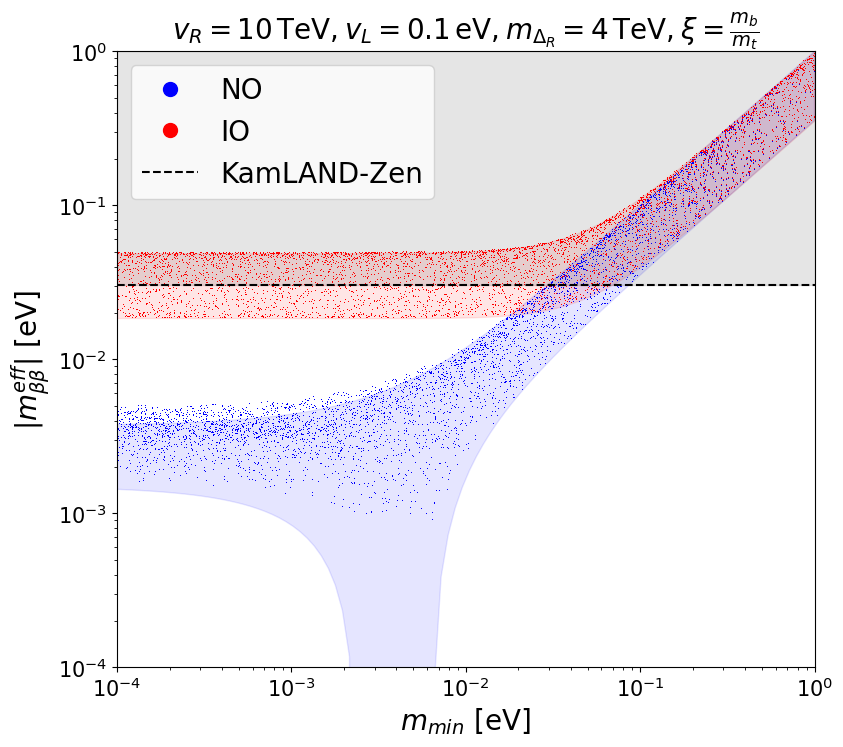

In [17]:
plt.figure(figsize = (9,8))
plt.plot(m, m_eff, ",", label = "NO", color = "b")
plt.plot(m, m_eff_IO, ",", label = "IO", color = "r")

cmap = plt.get_cmap("tab10")
legend_elements = [Line2D([0], [0], marker='o', label="NO", markersize=10, 
                          linewidth = 0, color = "b"),
               Line2D([0], [0], marker='o', label="IO", markersize=10, 
                      linewidth = 0, color = "r"),
               Line2D([0], [0], linestyle='--', label="KamLAND-Zen", color = "k")]

plt.ylabel(r"$|m_{\beta\beta}^{eff}|$ [eV]", fontsize = 20)
plt.xlabel(r"$m_{min}$ [eV]", fontsize = 20)
plt.fill_between(m_eff_standard["xNO"], 
                 m_eff_standard["m_eff_min (NO)"], 
                 m_eff_standard["m_eff_max (NO)"], alpha = 0.1, color = "b")
plt.fill_between(m_eff_standard["xNO"], 
                 m_eff_standard["m_eff_min (IO)"], 
                 m_eff_standard["m_eff_max (IO)"], alpha = 0.1, color = "r")
plt.axhline(KamLand_Limit, linestyle = "--", color = "k", label = "KamLAND-Zen")
plt.fill_between(m_eff_standard["xNO"], KamLand_Limit, 1, alpha = 0.1, color = "k")
plt.yscale("log")
plt.xscale("log")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlim([1e-4, 1])
plt.ylim([1e-4, 1])
plt.legend(handles = legend_elements, fontsize = 20, loc = "upper left")
plt.title(r"$v_R = 10\,\mathrm{TeV}, v_L = 0.1\,\mathrm{eV}, m_{\Delta_R} = 4\,\mathrm{TeV}, \xi = \frac{m_b}{m_t}$",
          fontsize = 20)
plt.savefig("mLRSM1.png", dpi = 150)

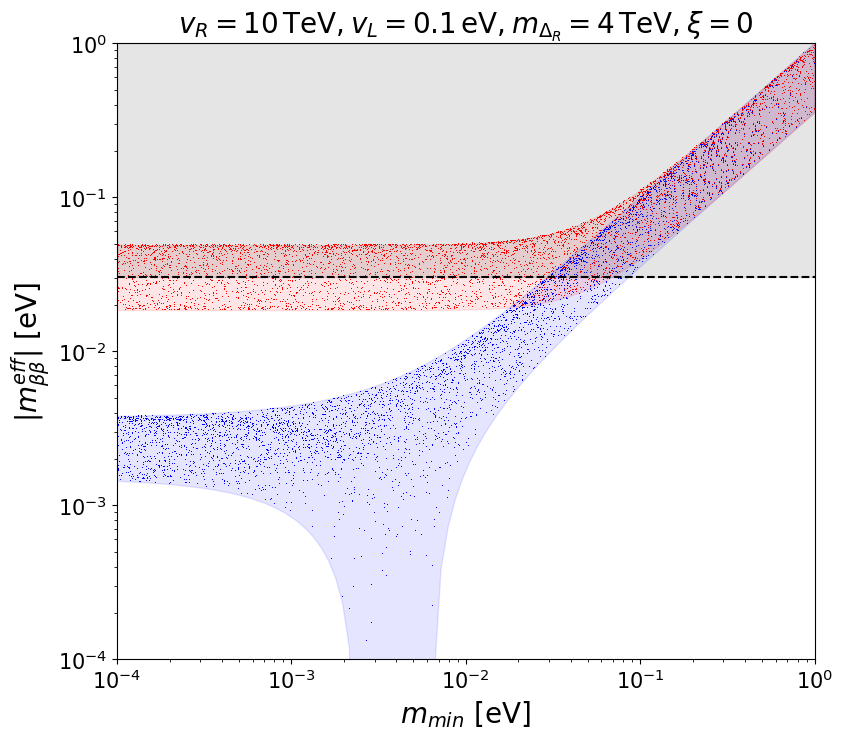

In [18]:
plt.figure(figsize = (9,8))
plt.plot(m2, m_eff2, ",", label = "NO", color = "b")
plt.plot(m2, m_eff_IO2, ",", label = "IO", color = "r")

cmap = plt.get_cmap("tab10")
legend_elements = [Line2D([0], [0], marker='o', label="NO", markersize=10, 
                          linewidth = 0, color = "b"),
               Line2D([0], [0], marker='o', label="IO", markersize=10, 
                      linewidth = 0, color = "r"),
               Line2D([0], [0], linestyle='--', label="KamLAND-Zen", color = "k")]

plt.ylabel(r"$|m_{\beta\beta}^{eff}|$ [eV]", fontsize = 20)
plt.xlabel(r"$m_{min}$ [eV]", fontsize = 20)
plt.fill_between(m_eff_standard["xNO"], 
                 m_eff_standard["m_eff_min (NO)"], 
                 m_eff_standard["m_eff_max (NO)"], alpha = 0.1, color = "b")
plt.fill_between(m_eff_standard["xNO"], 
                 m_eff_standard["m_eff_min (IO)"], 
                 m_eff_standard["m_eff_max (IO)"], alpha = 0.1, color = "r")
plt.axhline(KamLand_Limit, linestyle = "--", color = "k", label = "KamLAND-Zen")
plt.fill_between(m_eff_standard["xNO"], KamLand_Limit, 1, alpha = 0.1, color = "k")
plt.yscale("log")
plt.xscale("log")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlim([1e-4, 1])
plt.ylim([1e-4, 1])
plt.title(r"$v_R = 10\,\mathrm{TeV}, v_L = 0.1\,\mathrm{eV}, m_{\Delta_R} = 4\,\mathrm{TeV}, \xi = 0$",
          fontsize = 20)
plt.savefig("mLRSM2.png", dpi = 150)

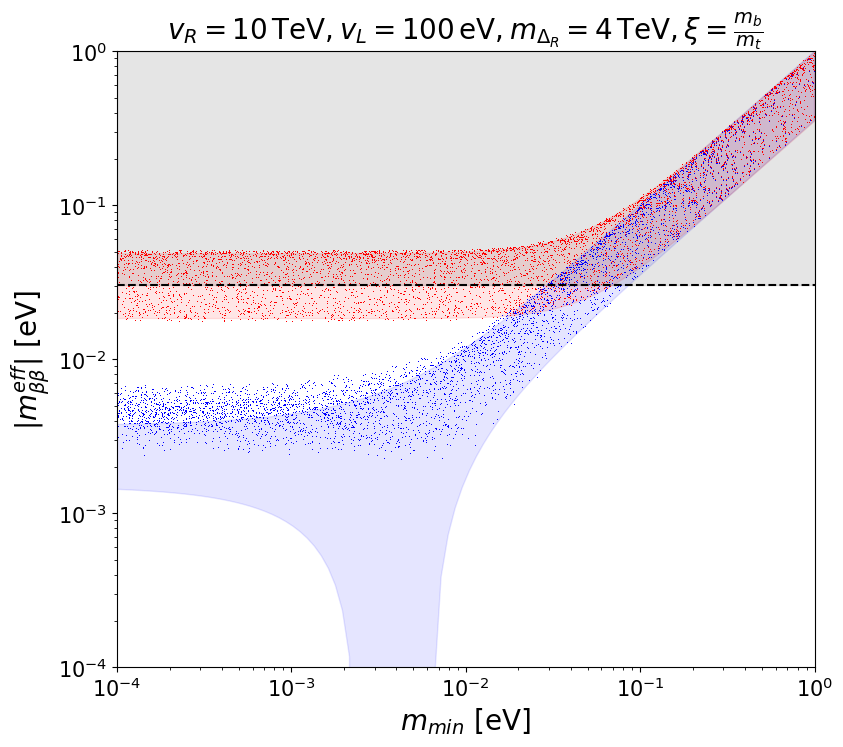

In [19]:
plt.figure(figsize = (9,8))
plt.plot(m3, m_eff3, ",", label = "NO", color = "b")
plt.plot(m3, m_eff_IO3, ",", label = "IO", color = "r")

cmap = plt.get_cmap("tab10")
legend_elements = [Line2D([0], [0], marker='o', label="NO", markersize=10, 
                          linewidth = 0, color = "b"),
               Line2D([0], [0], marker='o', label="IO", markersize=10, 
                      linewidth = 0, color = "r"),
               Line2D([0], [0], linestyle='--', label="KamLAND-Zen", color = "k")]

plt.ylabel(r"$|m_{\beta\beta}^{eff}|$ [eV]", fontsize = 20)
plt.xlabel(r"$m_{min}$ [eV]", fontsize = 20)
plt.fill_between(m_eff_standard["xNO"], 
                 m_eff_standard["m_eff_min (NO)"], 
                 m_eff_standard["m_eff_max (NO)"], alpha = 0.1, color = "b")
plt.fill_between(m_eff_standard["xNO"], 
                 m_eff_standard["m_eff_min (IO)"], 
                 m_eff_standard["m_eff_max (IO)"], alpha = 0.1, color = "r")
plt.axhline(KamLand_Limit, linestyle = "--", color = "k", label = "KamLAND-Zen")
plt.fill_between(m_eff_standard["xNO"], KamLand_Limit, 1, alpha = 0.1, color = "k")
plt.yscale("log")
plt.xscale("log")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlim([1e-4, 1])
plt.ylim([1e-4, 1])
plt.title(r"$v_R = 10\,\mathrm{TeV}, v_L = 100\,\mathrm{eV}, m_{\Delta_R} = 4\,\mathrm{TeV}, \xi = \frac{m_b}{m_t}$", 
          fontsize = 20)
plt.savefig("mLRSM3.png", dpi = 150)

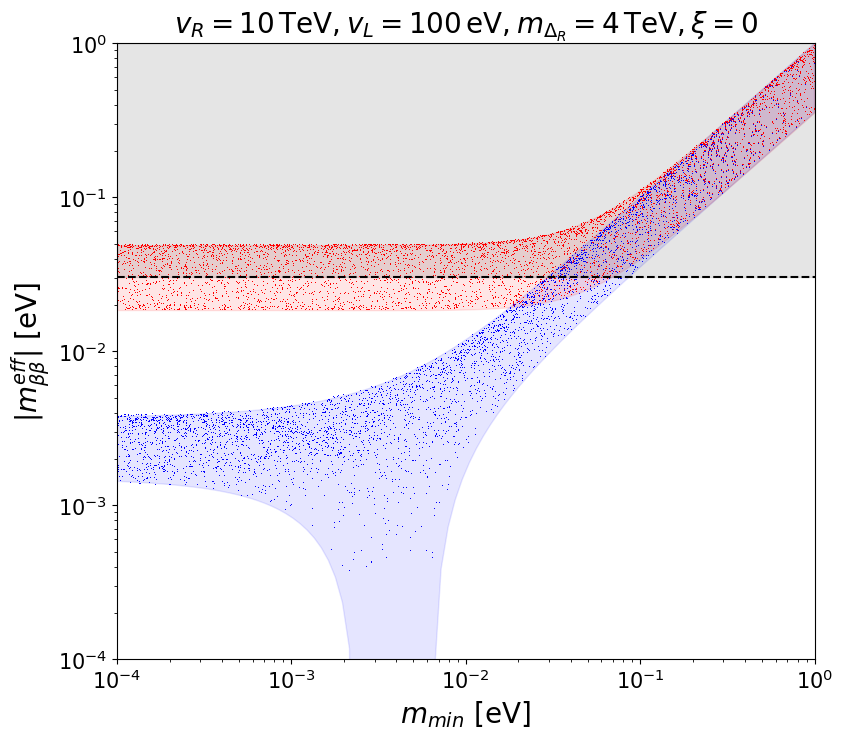

In [20]:
plt.figure(figsize = (9,8))
plt.plot(m4, m_eff4, ",", label = "NO", color = "b")
plt.plot(m4, m_eff_IO4, ",", label = "IO", color = "r")

cmap = plt.get_cmap("tab10")
legend_elements = [Line2D([0], [0], marker='o', label="NO", markersize=10, 
                          linewidth = 0, color = "b"),
               Line2D([0], [0], marker='o', label="IO", markersize=10, 
                      linewidth = 0, color = "r"),
               Line2D([0], [0], linestyle='--', label="KamLAND-Zen", color = "k")]

plt.ylabel(r"$|m_{\beta\beta}^{eff}|$ [eV]", fontsize = 20)
plt.xlabel(r"$m_{min}$ [eV]", fontsize = 20)
plt.fill_between(m_eff_standard["xNO"], 
                 m_eff_standard["m_eff_min (NO)"], 
                 m_eff_standard["m_eff_max (NO)"], alpha = 0.1, color = "b")
plt.fill_between(m_eff_standard["xNO"], 
                 m_eff_standard["m_eff_min (IO)"], 
                 m_eff_standard["m_eff_max (IO)"], alpha = 0.1, color = "r")
plt.axhline(KamLand_Limit, linestyle = "--", color = "k", label = "KamLAND-Zen")
plt.fill_between(m_eff_standard["xNO"], KamLand_Limit, 1, alpha = 0.1, color = "k")
plt.yscale("log")
plt.xscale("log")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlim([1e-4, 1])
plt.ylim([1e-4, 1])
plt.title(r"$v_R = 10\,\mathrm{TeV}, v_L = 100\,\mathrm{eV}, m_{\Delta_R} = 4\,\mathrm{TeV}, \xi = 0$", 
          fontsize = 20)
plt.savefig("mLRSM4.png", dpi = 150)

# 2.2 Normalized Plots
We can also normalize to the standard mechanism

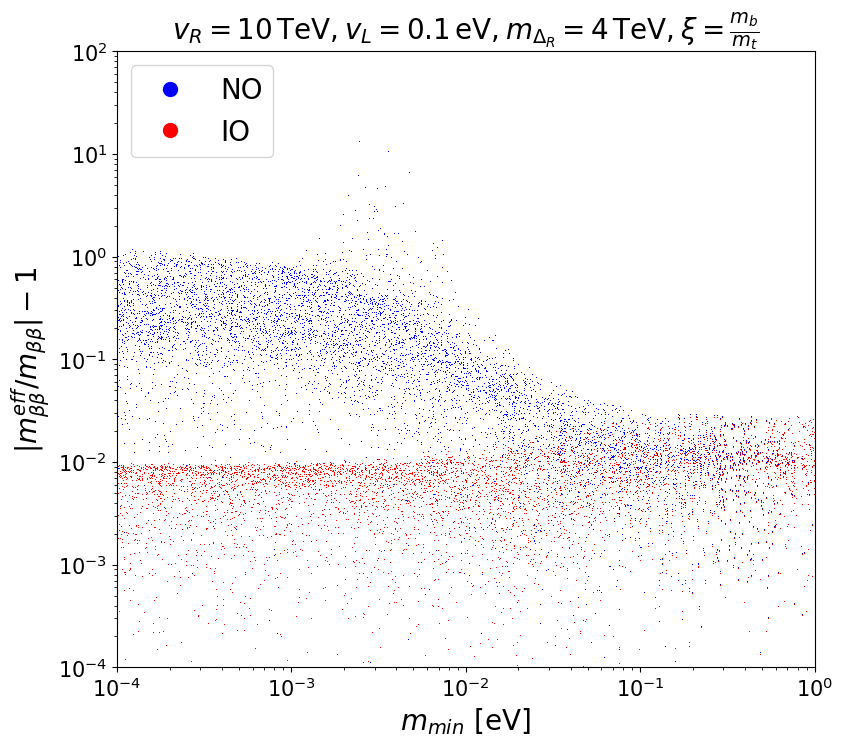

In [21]:
plt.figure(figsize = (9,8))
plt.plot(m_normalized, m_eff_normalized - 1, ",", label = "NO", color = "b")
plt.plot(m_normalized, m_eff_IO_normalized - 1, ",", label = "IO", color = "r")

cmap = plt.get_cmap("tab10")
legend_elements = [Line2D([0], [0], marker='o', label="NO", markersize=10, 
                          linewidth = 0, color = "b"),
               Line2D([0], [0], marker='o', label="IO", markersize=10, 
                      linewidth = 0, color = "r"),
                  ]

plt.ylabel(r"$|m_{\beta\beta}^{eff}/m_{\beta\beta}| - 1$", fontsize = 20)
plt.xlabel(r"$m_{min}$ [eV]", fontsize = 20)
plt.yscale("log")
plt.xscale("log")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlim([1e-4, 1])
plt.ylim([1e-4, 1e+2])
plt.legend(handles = legend_elements, fontsize = 20, loc = "upper left")
plt.title(r"$v_R = 10\,\mathrm{TeV}, v_L = 0.1\,\mathrm{eV}, m_{\Delta_R} = 4\,\mathrm{TeV}, \xi = \frac{m_b}{m_t}$",
          fontsize = 20)
plt.savefig("mLRSM1_norm.png", dpi = 150)

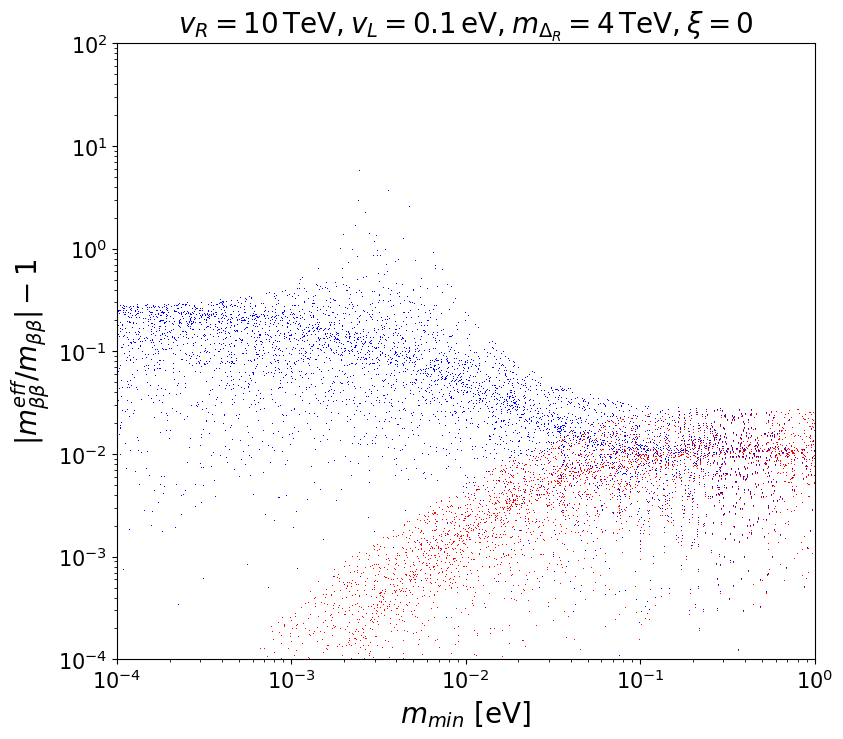

In [22]:
plt.figure(figsize = (9,8))
plt.plot(m2_normalized, m_eff2_normalized - 1, ",", label = "NO", color = "b")
plt.plot(m2_normalized, m_eff_IO2_normalized - 1, ",", label = "IO", color = "r")

cmap = plt.get_cmap("tab10")
legend_elements = [Line2D([0], [0], marker='o', label="NO", markersize=10, 
                          linewidth = 0, color = "b"),
               Line2D([0], [0], marker='o', label="IO", markersize=10, 
                      linewidth = 0, color = "r"),
                  ]

plt.ylabel(r"$|m_{\beta\beta}^{eff}/m_{\beta\beta}| - 1$", fontsize = 20)
plt.xlabel(r"$m_{min}$ [eV]", fontsize = 20)
plt.yscale("log")
plt.xscale("log")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlim([1e-4, 1])
plt.ylim([1e-4, 1e+2])
plt.title(r"$v_R = 10\,\mathrm{TeV}, v_L = 0.1\,\mathrm{eV}, m_{\Delta_R} = 4\,\mathrm{TeV}, \xi = 0$",
          fontsize = 20)
plt.savefig("mLRSM2_norm.png", dpi = 150)

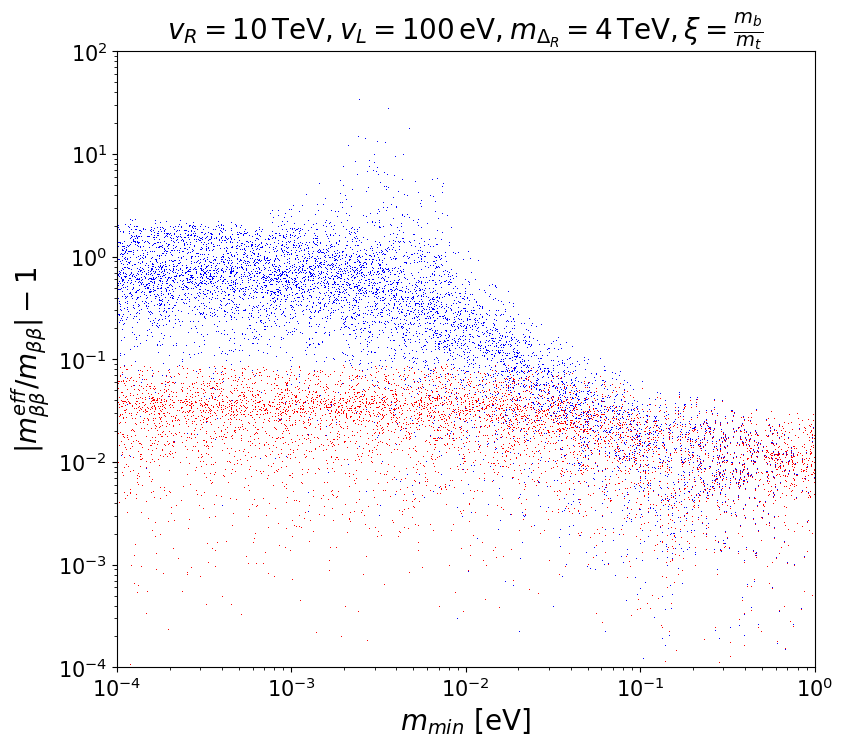

In [23]:
plt.figure(figsize = (9,8))
plt.plot(m3_normalized, m_eff3_normalized - 1, ",", label = "NO", color = "b")
plt.plot(m3_normalized, m_eff_IO3_normalized - 1, ",", label = "IO", color = "r")

cmap = plt.get_cmap("tab10")
legend_elements = [Line2D([0], [0], marker='o', label="NO", markersize=10, 
                          linewidth = 0, color = "b"),
               Line2D([0], [0], marker='o', label="IO", markersize=10, 
                      linewidth = 0, color = "r"),
                  ]

plt.ylabel(r"$|m_{\beta\beta}^{eff}/m_{\beta\beta}| - 1$", fontsize = 20)
plt.xlabel(r"$m_{min}$ [eV]", fontsize = 20)
plt.yscale("log")
plt.xscale("log")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlim([1e-4, 1])
plt.ylim([1e-4, 1e+2])
plt.title(r"$v_R = 10\,\mathrm{TeV}, v_L = 100\,\mathrm{eV}, m_{\Delta_R} = 4\,\mathrm{TeV}, \xi = \frac{m_b}{m_t}$",
          fontsize = 20)
plt.savefig("mLRSM3_norm.png", dpi = 150)

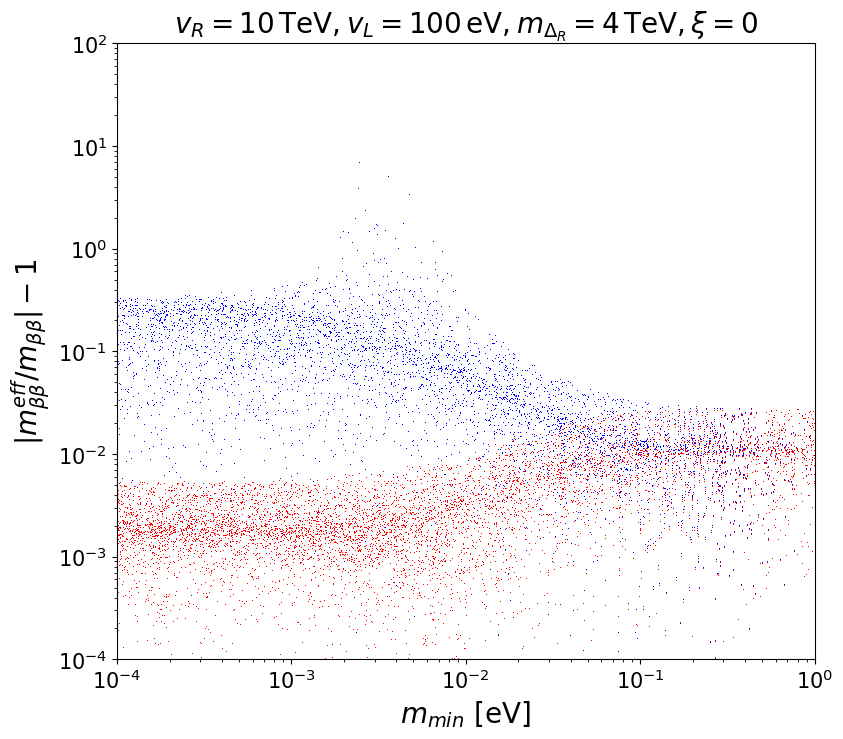

In [24]:
plt.figure(figsize = (9,8))
plt.plot(m4_normalized, m_eff4_normalized - 1, ",", label = "NO", color = "b")
plt.plot(m4_normalized, m_eff_IO4_normalized - 1, ",", label = "IO", color = "r")

cmap = plt.get_cmap("tab10")
legend_elements = [Line2D([0], [0], marker='o', label="NO", markersize=10, 
                          linewidth = 0, color = "b"),
               Line2D([0], [0], marker='o', label="IO", markersize=10, 
                      linewidth = 0, color = "r"),
                  ]

plt.ylabel(r"$|m_{\beta\beta}^{eff}/m_{\beta\beta}| - 1$", fontsize = 20)
plt.xlabel(r"$m_{min}$ [eV]", fontsize = 20)
plt.yscale("log")
plt.xscale("log")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlim([1e-4, 1])
plt.ylim([1e-4, 1e+2])
plt.title(r"$v_R = 10\,\mathrm{TeV}, v_L = 100\,\mathrm{eV}, m_{\Delta_R} = 4\,\mathrm{TeV}, \xi = 0$",
          fontsize = 20)
plt.savefig("mLRSM4_norm.png", dpi = 150)

# 3. Separate Contributions Short- vs Long-Range

This will take even longer than previously. You might want to skip this.

In [25]:
########################################################################################################
(m_normalized_short, t_normalized_short, 
 tIO_normalized_short, m_eff_normalized_short, 
 m_eff_IO_normalized_short) = get_points(N = N, 
                                        v_R     = 10*TeV, 
                                        v_L     = 0.1*eV, 
                                        m_DR    = 4*TeV, 
                                        m_heavy = np.array([10,12,13])*TeV, 
                                        xi      = m_b/m_t,
                                        normalize = True, 
                                        WC_option = 1
                                       )
print(time.time()-start)

start = time.time()
(m2_normalized_short, t2_normalized_short, 
 tIO2_normalized_short, m_eff2_normalized_short, 
 m_eff_IO2_normalized_short) = get_points(N = N, 
                                          v_R       = 10*TeV, 
                                          v_L       = 0.1*eV, 
                                          m_DR      = 4*TeV, 
                                          m_heavy   = np.array([10,12,13])*TeV, 
                                          xi        = 0,
                                          normalize = True, 
                                          WC_option = 1
                                         )
print(time.time()-start)

start = time.time()
(m3_normalized_short, t3_normalized_short, 
 tIO3_normalized_short, m_eff3_normalized_short, 
 m_eff_IO3_normalized_short) = get_points(N       = N, 
                                          v_R     = 10*TeV, 
                                          v_L     = 100*eV, 
                                          m_DR    = 4*TeV, 
                                          m_heavy = np.array([10,12,13])*TeV, 
                                          xi      = m_b/m_t,
                                          normalize = True,
                                          WC_option = 1,
                                         )
print(time.time()-start)

start = time.time()
(m4_normalized_short, t4_normalized_short, 
 tIO4_normalized_short, m_eff4_normalized_short, 
 m_eff_IO4_normalized_short)= get_points(N       = N, 
                                         v_R     = 10*TeV, 
                                         v_L     = 100*eV, 
                                         m_DR    = 4*TeV, 
                                         m_heavy = np.array([10,12,13])*TeV, 
                                         xi      = 0,
                                         normalize = True, 
                                         WC_option = 1,
                                        )
########################################################################################################
(m_normalized_long, t_normalized_long, 
 tIO_normalized_long, m_eff_normalized_long, 
 m_eff_IO_normalized_long) = get_points(N = N, 
                                        v_R     = 10*TeV, 
                                        v_L     = 0.1*eV, 
                                        m_DR    = 4*TeV, 
                                        m_heavy = np.array([10,12,13])*TeV, 
                                        xi      = m_b/m_t,
                                        normalize = True, 
                                        WC_option = 2
                                       )
print(time.time()-start)

start = time.time()
(m2_normalized_long, t2_normalized_long, 
 tIO2_normalized_long, m_eff2_normalized_long,
 m_eff_IO2_normalized_long) = get_points(N = N, 
                                        v_R       = 10*TeV, 
                                        v_L       = 0.1*eV, 
                                        m_DR      = 4*TeV, 
                                        m_heavy   = np.array([10,12,13])*TeV, 
                                        xi        = 0,
                                        normalize = True, 
                                         WC_option = 2
                                       )
print(time.time()-start)

start = time.time()
(m3_normalized_long, t3_normalized_long, 
 tIO3_normalized_long, m_eff3_normalized_long, 
 m_eff_IO3_normalized_long) = get_points(N       = N, 
                                         v_R     = 10*TeV, 
                                         v_L     = 100*eV, 
                                         m_DR    = 4*TeV, 
                                         m_heavy = np.array([10,12,13])*TeV, 
                                         xi      = m_b/m_t,
                                         normalize = True,
                                         WC_option = 2
                                        )
print(time.time()-start)

start = time.time()
(m4_normalized_long, t4_normalized_long,
 tIO4_normalized_long, m_eff4_normalized_long,
 m_eff_IO4_normalized_long) = get_points(N       = N, 
                                         v_R     = 10*TeV, 
                                         v_L     = 100*eV, 
                                         m_DR    = 4*TeV, 
                                         m_heavy = np.array([10,12,13])*TeV, 
                                         xi      = 0,
                                         normalize = True,
                                         WC_option = 2
                                        )
print(time.time()-start)

0.0%
1.0%
2.0%
3.0%
4.0%
5.0%
6.0%
7.0%
8.0%
9.0%
10.0%
11.0%
12.0%
13.0%
14.0%
15.0%
16.0%
17.0%
18.0%
19.0%
20.0%
21.0%
22.0%
23.0%
24.0%
25.0%
26.0%
27.0%
28.0%
29.0%
30.0%
31.0%
32.0%
33.0%
34.0%
35.0%
36.0%
37.0%
38.0%
39.0%
40.0%
41.0%
42.0%
43.0%
44.0%
45.0%
46.0%
47.0%
48.0%
49.0%
50.0%
51.0%
52.0%
53.0%
54.0%
55.0%
56.0%
57.0%
58.0%
59.0%
60.0%
61.0%
62.0%
63.0%
64.0%
65.0%
66.0%
67.0%
68.0%
69.0%
70.0%
71.0%
72.0%
73.0%
74.0%
75.0%
76.0%
77.0%
78.0%
79.0%
80.0%
81.0%
82.0%
83.0%
84.0%
85.0%
86.0%
87.0%
88.0%
89.0%
90.0%
91.0%
92.0%
93.0%
94.0%
95.0%
96.0%
97.0%
98.0%
99.0%
458.87711095809937
0.0%
1.0%
2.0%
3.0%
4.0%
5.0%
6.0%
7.0%
8.0%
9.0%
10.0%
11.0%
12.0%
13.0%
14.0%
15.0%
16.0%
17.0%
18.0%
19.0%
20.0%
21.0%
22.0%
23.0%
24.0%
25.0%
26.0%
27.0%
28.0%
29.0%
30.0%
31.0%
32.0%
33.0%
34.0%
35.0%
36.0%
37.0%
38.0%
39.0%
40.0%
41.0%
42.0%
43.0%
44.0%
45.0%
46.0%
47.0%
48.0%
49.0%
50.0%
51.0%
52.0%
53.0%
54.0%
55.0%
56.0%
57.0%
58.0%
59.0%
60.0%
61.0%
62.0%
63.0%
64.0%
65.0%
66.0%

## Long-Range

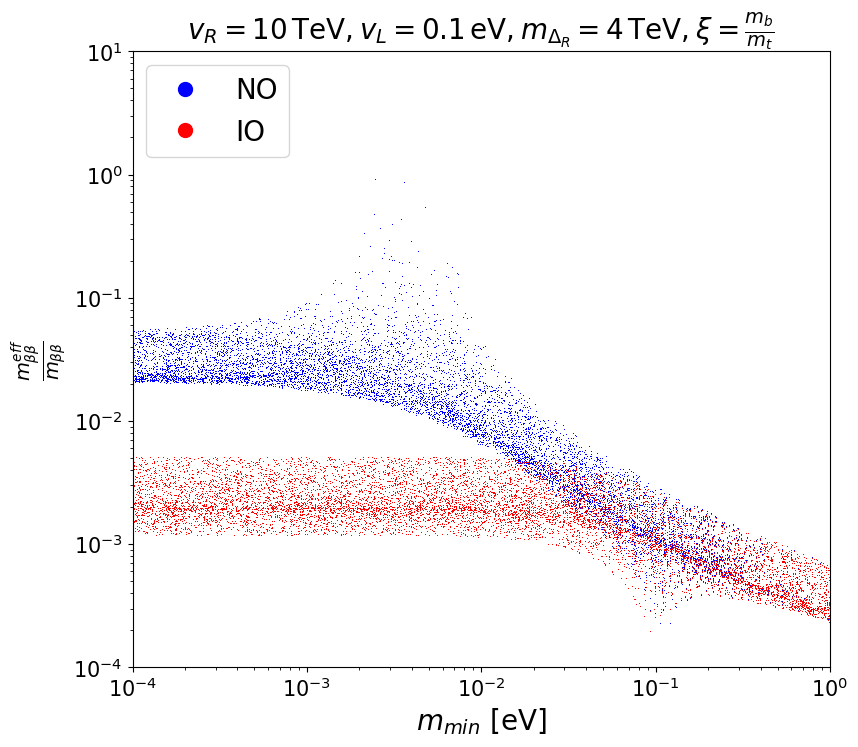

In [26]:
plt.figure(figsize = (9,8))
plt.plot(m_normalized_long, m_eff_normalized_long, ",", label = "NO", color = "b")
plt.plot(m_normalized_long, m_eff_IO_normalized_long, ",", label = "IO", color = "r")

cmap = plt.get_cmap("tab10")
legend_elements = [Line2D([0], [0], marker='o', label="NO", markersize=10, 
                          linewidth = 0, color = "b"),
               Line2D([0], [0], marker='o', label="IO", markersize=10, 
                      linewidth = 0, color = "r"),
                  ]

plt.ylabel(r"$\frac{m_{\beta\beta}^{eff}}{m_{\beta\beta}}$", fontsize = 20)
plt.xlabel(r"$m_{min}$ [eV]", fontsize = 20)
plt.yscale("log")
plt.xscale("log")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlim([1e-4, 1])
plt.ylim([1e-4, 1e+1])
plt.legend(handles = legend_elements, fontsize = 20, loc = "upper left")
#plt.tight_layout()
plt.title(r"$v_R = 10\,\mathrm{TeV}, v_L = 0.1\,\mathrm{eV}, m_{\Delta_R} = 4\,\mathrm{TeV}, \xi = \frac{m_b}{m_t}$",
          fontsize = 20)
plt.savefig("mLRSM1_long_norm.png", dpi = 150)

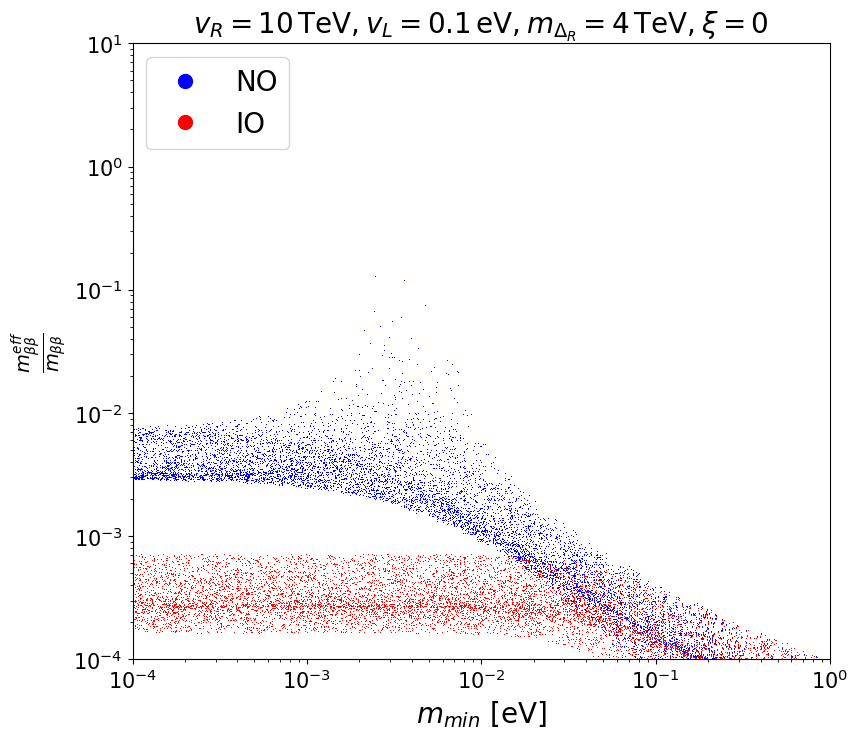

In [27]:
plt.figure(figsize = (9,8))
plt.plot(m2_normalized_long, m_eff2_normalized_long, ",", label = "NO", color = "b")
plt.plot(m2_normalized_long, m_eff_IO2_normalized_long, ",", label = "IO", color = "r")

cmap = plt.get_cmap("tab10")
legend_elements = [Line2D([0], [0], marker='o', label="NO", markersize=10, 
                          linewidth = 0, color = "b"),
               Line2D([0], [0], marker='o', label="IO", markersize=10, 
                      linewidth = 0, color = "r"),
                  ]

plt.ylabel(r"$\frac{m_{\beta\beta}^{eff}}{m_{\beta\beta}}$", fontsize = 20)
plt.xlabel(r"$m_{min}$ [eV]", fontsize = 20)
plt.yscale("log")
plt.xscale("log")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlim([1e-4, 1])
plt.ylim([1e-4, 1e+1])
plt.legend(handles = legend_elements, fontsize = 20, loc = "upper left")
plt.title(r"$v_R = 10\,\mathrm{TeV}, v_L = 0.1\,\mathrm{eV}, m_{\Delta_R} = 4\,\mathrm{TeV}, \xi = 0$",
          fontsize = 20)
plt.savefig("mLRSM2_long_norm.png", dpi = 150)

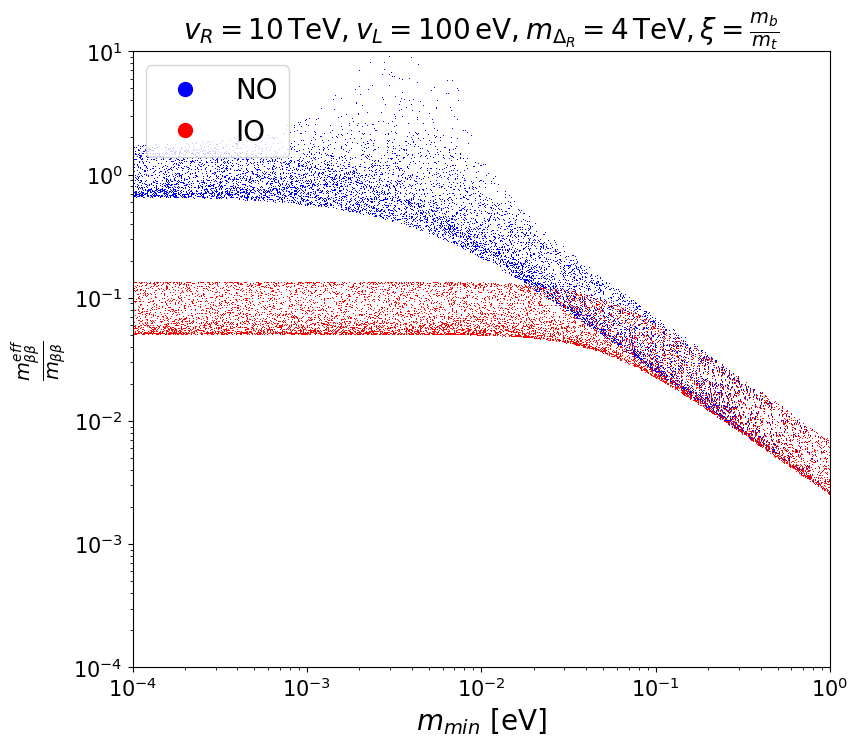

In [28]:
plt.figure(figsize = (9,8))
plt.plot(m3_normalized_long, m_eff3_normalized_long, ",", label = "NO", color = "b")
plt.plot(m3_normalized_long, m_eff_IO3_normalized_long, ",", label = "IO", color = "r")

cmap = plt.get_cmap("tab10")
legend_elements = [Line2D([0], [0], marker='o', label="NO", markersize=10, 
                          linewidth = 0, color = "b"),
               Line2D([0], [0], marker='o', label="IO", markersize=10, 
                      linewidth = 0, color = "r"),
                  ]

plt.ylabel(r"$\frac{m_{\beta\beta}^{eff}}{m_{\beta\beta}}$", fontsize = 20)
plt.xlabel(r"$m_{min}$ [eV]", fontsize = 20)
plt.yscale("log")
plt.xscale("log")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlim([1e-4, 1])
plt.ylim([1e-4, 1e+1])
plt.legend(handles = legend_elements, fontsize = 20, loc = "upper left")
plt.title(r"$v_R = 10\,\mathrm{TeV}, v_L = 100\,\mathrm{eV}, m_{\Delta_R} = 4\,\mathrm{TeV}, \xi = \frac{m_b}{m_t}$",
          fontsize = 20)
plt.savefig("mLRSM3_long_norm.png", dpi = 150)

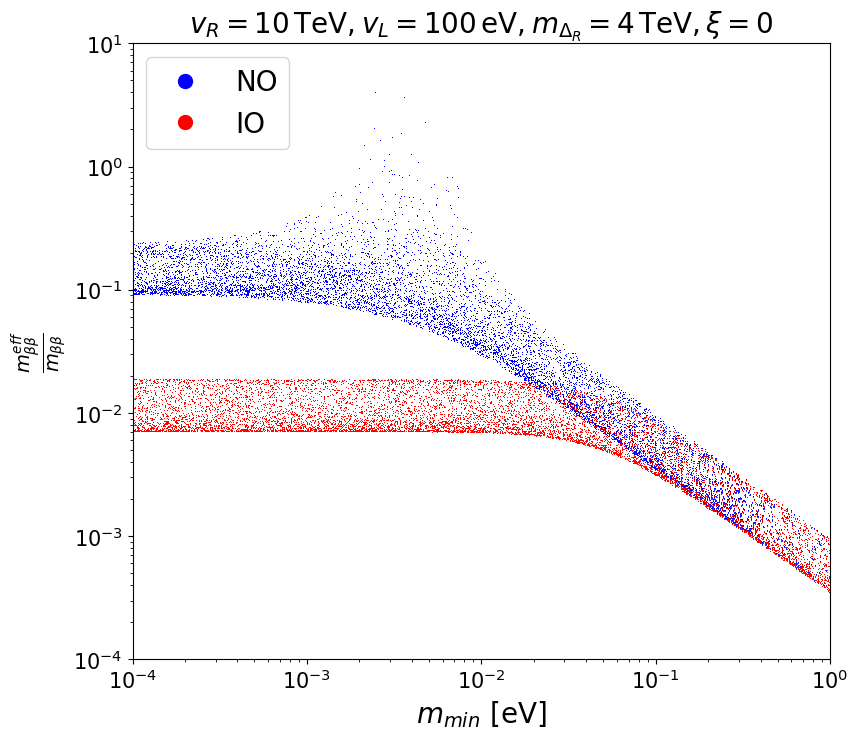

In [29]:
plt.figure(figsize = (9,8))
plt.plot(m4_normalized_long, m_eff4_normalized_long, ",", label = "NO", color = "b")
plt.plot(m4_normalized_long, m_eff_IO4_normalized_long, ",", label = "IO", color = "r")

cmap = plt.get_cmap("tab10")
legend_elements = [Line2D([0], [0], marker='o', label="NO", markersize=10, 
                          linewidth = 0, color = "b"),
               Line2D([0], [0], marker='o', label="IO", markersize=10, 
                      linewidth = 0, color = "r"),
                  ]

plt.ylabel(r"$\frac{m_{\beta\beta}^{eff}}{m_{\beta\beta}}$", fontsize = 20)
plt.xlabel(r"$m_{min}$ [eV]", fontsize = 20)
plt.yscale("log")
plt.xscale("log")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlim([1e-4, 1])
plt.ylim([1e-4, 1e+1])
plt.legend(handles = legend_elements, fontsize = 20, loc = "upper left")
plt.title(r"$v_R = 10\,\mathrm{TeV}, v_L = 100\,\mathrm{eV}, m_{\Delta_R} = 4\,\mathrm{TeV}, \xi = 0$",
          fontsize = 20)
plt.savefig("mLRSM4_long_norm.png", dpi = 150)

## Short-Range

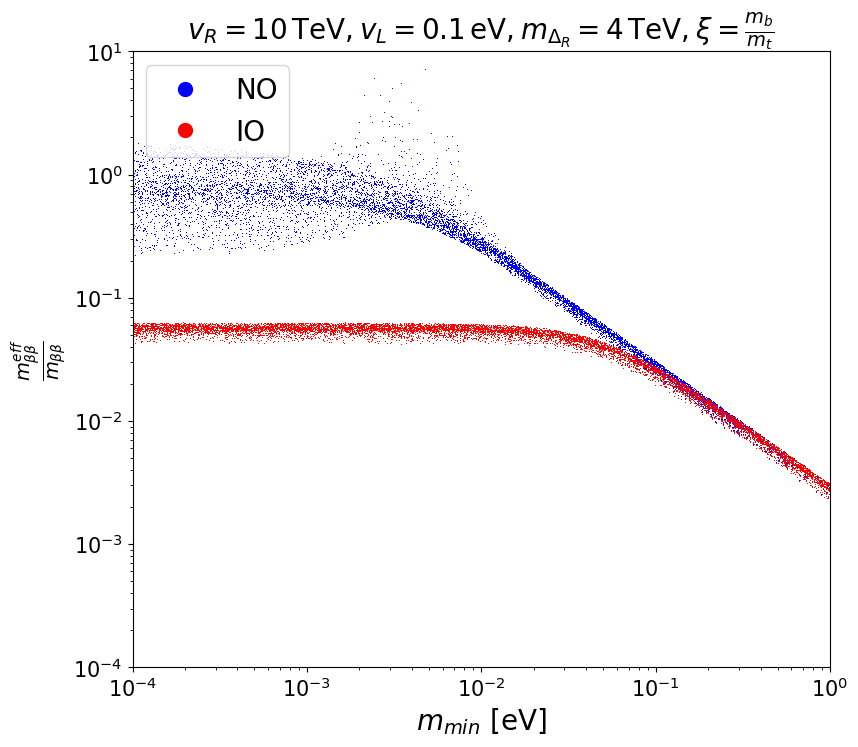

In [30]:
plt.figure(figsize = (9,8))
plt.plot(m_normalized_short, m_eff_normalized_short, ",", label = "NO", color = "b")
plt.plot(m_normalized_short, m_eff_IO_normalized_short, ",", label = "IO", color = "r")

cmap = plt.get_cmap("tab10")
legend_elements = [Line2D([0], [0], marker='o', label="NO", markersize=10, 
                          linewidth = 0, color = "b"),
               Line2D([0], [0], marker='o', label="IO", markersize=10, 
                      linewidth = 0, color = "r"),
                  ]

plt.ylabel(r"$\frac{m_{\beta\beta}^{eff}}{m_{\beta\beta}}$", fontsize = 20)
plt.xlabel(r"$m_{min}$ [eV]", fontsize = 20)
plt.yscale("log")
plt.xscale("log")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlim([1e-4, 1])
plt.ylim([1e-4, 1e+1])
plt.legend(handles = legend_elements, fontsize = 20, loc = "upper left")
plt.title(r"$v_R = 10\,\mathrm{TeV}, v_L = 0.1\,\mathrm{eV}, m_{\Delta_R} = 4\,\mathrm{TeV}, \xi = \frac{m_b}{m_t}$",
          fontsize = 20)
plt.savefig("mLRSM1_short_norm.png", dpi = 150)

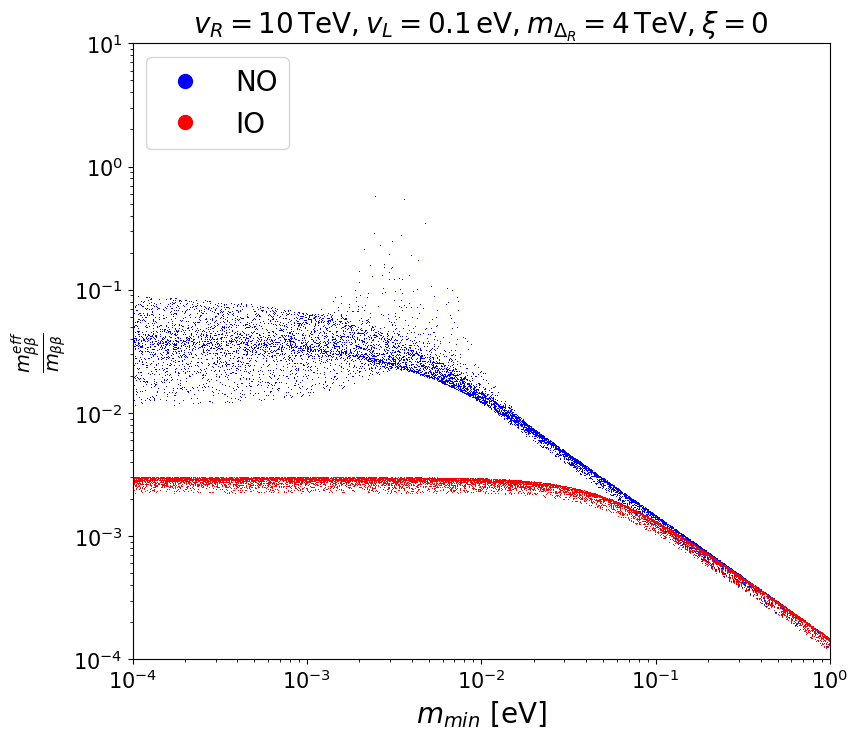

In [31]:
plt.figure(figsize = (9,8))
plt.plot(m2_normalized_short, m_eff2_normalized_short, ",", label = "NO", color = "b")
plt.plot(m2_normalized_short, m_eff_IO2_normalized_short, ",", label = "IO", color = "r")

cmap = plt.get_cmap("tab10")
legend_elements = [Line2D([0], [0], marker='o', label="NO", markersize=10, 
                          linewidth = 0, color = "b"),
               Line2D([0], [0], marker='o', label="IO", markersize=10, 
                      linewidth = 0, color = "r"),
                  ]

plt.ylabel(r"$\frac{m_{\beta\beta}^{eff}}{m_{\beta\beta}}$", fontsize = 20)
plt.xlabel(r"$m_{min}$ [eV]", fontsize = 20)
plt.yscale("log")
plt.xscale("log")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlim([1e-4, 1])
plt.ylim([1e-4, 1e+1])
plt.legend(handles = legend_elements, fontsize = 20, loc = "upper left")
plt.title(r"$v_R = 10\,\mathrm{TeV}, v_L = 0.1\,\mathrm{eV}, m_{\Delta_R} = 4\,\mathrm{TeV}, \xi = 0$",
          fontsize = 20)
plt.savefig("mLRSM1_short_norm.png", dpi = 150)

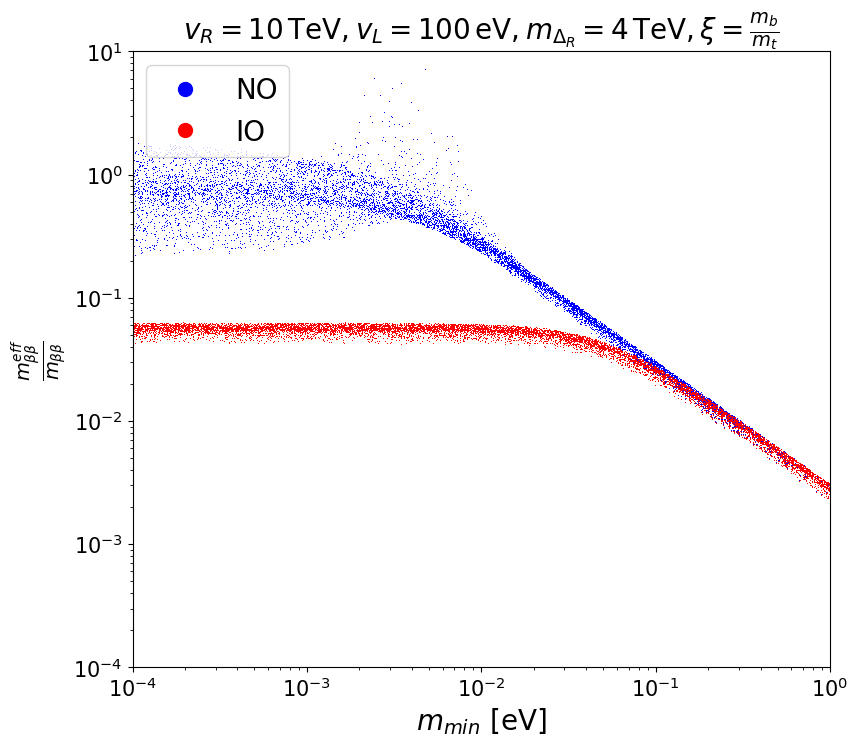

In [32]:
plt.figure(figsize = (9,8))
plt.plot(m3_normalized_short, m_eff3_normalized_short, ",", label = "NO", color = "b")
plt.plot(m3_normalized_short, m_eff_IO3_normalized_short, ",", label = "IO", color = "r")

cmap = plt.get_cmap("tab10")
legend_elements = [Line2D([0], [0], marker='o', label="NO", markersize=10, 
                          linewidth = 0, color = "b"),
               Line2D([0], [0], marker='o', label="IO", markersize=10, 
                      linewidth = 0, color = "r"),
                  ]

plt.ylabel(r"$\frac{m_{\beta\beta}^{eff}}{m_{\beta\beta}}$", fontsize = 20)
plt.xlabel(r"$m_{min}$ [eV]", fontsize = 20)
plt.yscale("log")
plt.xscale("log")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlim([1e-4, 1])
plt.ylim([1e-4, 1e+1])
plt.legend(handles = legend_elements, fontsize = 20, loc = "upper left")
plt.title(r"$v_R = 10\,\mathrm{TeV}, v_L = 100\,\mathrm{eV}, m_{\Delta_R} = 4\,\mathrm{TeV}, \xi = \frac{m_b}{m_t}$",
          fontsize = 20)
plt.savefig("mLRSM3_short_norm.png", dpi = 150)

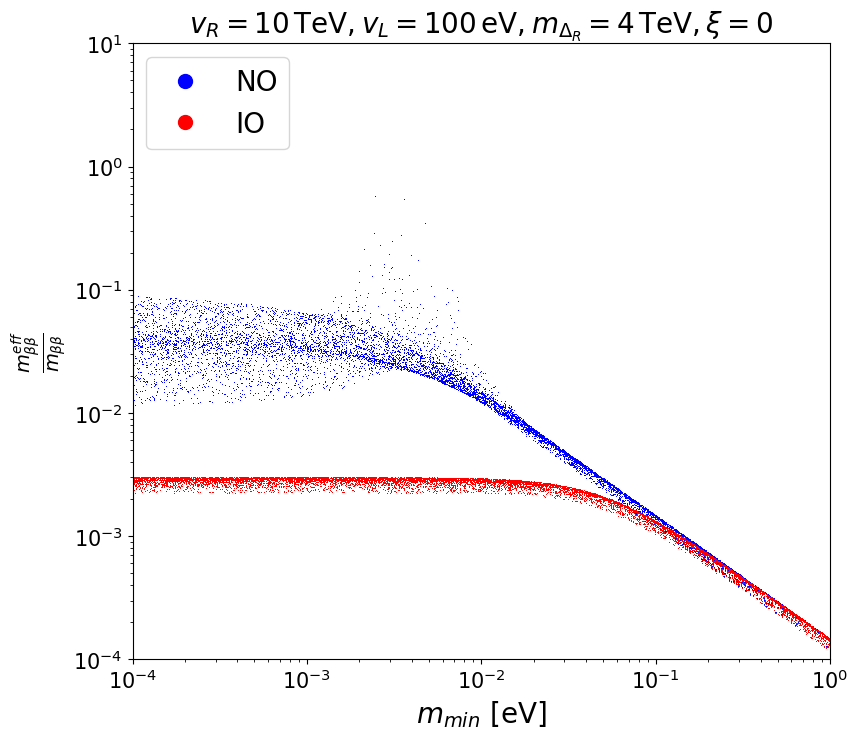

In [33]:
plt.figure(figsize = (9,8))
plt.plot(m4_normalized_short, m_eff4_normalized_short, ",", label = "NO", color = "b")
plt.plot(m4_normalized_short, m_eff_IO4_normalized_short, ",", label = "IO", color = "r")

cmap = plt.get_cmap("tab10")
legend_elements = [Line2D([0], [0], marker='o', label="NO", markersize=10, 
                          linewidth = 0, color = "b"),
               Line2D([0], [0], marker='o', label="IO", markersize=10, 
                      linewidth = 0, color = "r"),
                  ]

plt.ylabel(r"$\frac{m_{\beta\beta}^{eff}}{m_{\beta\beta}}$", fontsize = 20)
plt.xlabel(r"$m_{min}$ [eV]", fontsize = 20)
plt.yscale("log")
plt.xscale("log")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlim([1e-4, 1])
plt.ylim([1e-4, 1e+1])
plt.legend(handles = legend_elements, fontsize = 20, loc = "upper left")
plt.title(r"$v_R = 10\,\mathrm{TeV}, v_L = 100\,\mathrm{eV}, m_{\Delta_R} = 4\,\mathrm{TeV}, \xi = 0$",
          fontsize = 20)
plt.savefig("mLRSM4_short_norm.png", dpi = 150)